In [1]:
import matplotlib.pyplot as plt
import torch
import datetime
import os
import json
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
)
import numpy as np
from main_pygod import get_data_from_loader, load_dataset, make_loader, transform_data, create_model, train_model, test_model
import warnings

In [2]:
def create_metrics():
    return {"overall": {"roc_auc": [], "accuracy": [],"f1": [], "precision": [], "recall": []},
            "licit": {"precision": [], "recall": [],"f1-score": []}, 
           "illicit":{"precision": [], "recall": [],"f1-score": []}}

def hyperparameter_loop(group_para, parameter, parameter_list, metrics):
    """ 
    Run a grid search for a hyperparameter
    Args: hyperparameter, hyperparameter list, classification metrics (empty dict)
    Returns: Classification metrics dictionary
    """ 
    warnings.filterwarnings('ignore')
    for i in range(len(parameter_list)):
        config[group_para][parameter] = parameter_list[i]
        timestamp = config["model"]["backbone"]+"_hid_dim"+str(config["model"]["hid_dim"])+"_num_l"+str(config["model"]["num_layers"])
        timestamp += "_dropout"+str(config["model"]["dropout"])+ "_epoch"+str(config["model"]["epoch"])
        
        dataset, input_nodes = load_dataset(mask="train",use_aggregated=config["data"]["use_aggregated"],use_temporal=config["data"]["use_temporal"])
        loader = make_loader(data=dataset, loader_type='neighbor', batch_size=config["data"]["batch_size"], input_nodes=input_nodes)
        train_data1 = get_data_from_loader(loader)
        train_data2 = transform_data(train_data1, perturb=config['transform']['perturb'], 
                                interpolate=config['transform']['interpolate'])

        mymodel = create_model(config=config["model"])

        train_clean = train_model(mymodel, train_data1, output_directory=config["training"]["save_dir"], 
                                    save_embeddings=config["training"]["save_embeddings"], timestamp=timestamp)
        trained_model = train_model(train_clean, train_data2, output_directory=config["training"]["save_dir"], 
                                    save_embeddings=config["training"]["save_embeddings"], timestamp=timestamp)
        
        dataset, input_nodes = load_dataset(mask="test",use_aggregated=config["data"]["use_aggregated"],
        use_temporal=config["data"]["use_temporal"])
        loader = make_loader(data=dataset, loader_type='neighbor', batch_size=config["data"]["batch_size"], input_nodes=input_nodes,)    
        test_data = get_data_from_loader(loader)

        test_metrics = test_model(model=trained_model, data=test_data, output_directory=config["training"]["save_dir"], timestamp=timestamp)

        for key in list(test_metrics.keys())[0:-1]:
            metrics["overall"][key].append(test_metrics[key])
        output = test_metrics["classification_report"]
        for key in list(output["0"].keys())[0:-1]:
            metrics["licit"][key].append(output["0"][key])
            metrics["illicit"][key].append(output["1"][key])
            
    return metrics

def plot_metrics(metrics, para_list, parameter, x_log = False):
    """
    Plot the classification metrics
    Args:classification metrics
    Returns:None
    """ 

    size = (8,3)
    plt.figure(figsize= size)
    for key in list(metrics["overall"]):
        plt.plot(para_list, metrics["overall"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Total Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Overall Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= size)
    for key in list(metrics["licit"]):
        plt.plot(para_list, metrics["licit"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Licit Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Licit Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= size)
    for key in list(metrics["illicit"]):
        plt.plot(para_list, metrics["illicit"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Illicit Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Illicit Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()

## Base DOMINANT

In [4]:
config = {
        "model": {
            "hid_dim": 128,
            "num_layers": 5,
            "dropout": 0.2,
            "weight_decay": 0.0,
            "contamination": 0.1,
            "backbone": "gcn",
            "lr": 0.005,
            "epoch": 30,
            "gpu":0.9,
            "batch_size": 2048,
            "num_neigh": 10,
            "weight": 0.5,
            "verbose": 1,
        },
        "data": {
            "use_aggregated": False,
            "use_temporal": False,
            "batch_size": 10000
        },
        "training": {
            "save_embeddings": False,
            "save_dir": "./saved_models",
        },
        "classifiers": ["rf", "mlp"],
        "transform":{
            "perturb":True,
            "interpolate":False,
        }
    }

#### Number of layers

In [6]:
metrics = create_metrics()
para_change = "num_layers"
para_list = [3,4,5,6]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[20148, 93], edge_index=[2, 19902], y=[20148])
Using perturbation
creating model with {'hid_dim': 128, 'num_layers': 3, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'torch_geometric.nn.models.basic_gnn.GCN'>}
training model...
Epoch 0000: Loss 3603.2816 | 
Epoch 0001: Loss 3707.8231 | 
Epoch 0002: Loss 792.4892 | 
Epoch 0003: Loss 314.0257 | 
Epoch 0004: Loss 199.5002 | 
Epoch 0005: Loss 122.8604 | 
Epoch 0006: Loss 89.8734 | 
Epoch 0007: Loss 83.5036 | 
Epoch 0008: Loss 95.1214 | 
Epoch 0009: Loss 142.0538 | 
Epoch 0010: Loss 196.9808 | 
Epoch 0011: Loss 209.0161 | 
Epoch 0012: Loss 111.8761 | 
Epoch 0013: Loss 68.0197 | 
Epoch 0014: Loss 59.9536 | 
Epoch 0015: Loss 66.7743 | 
Epoch 0016: Loss 80.8531 | 
Epoch 0017: Loss 96.7116 | 
Epoch 0018: Loss 99.63

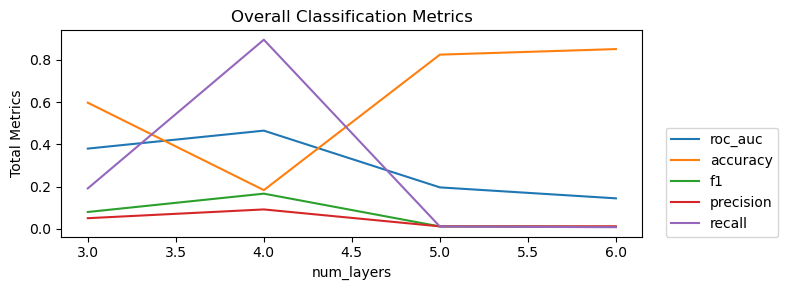

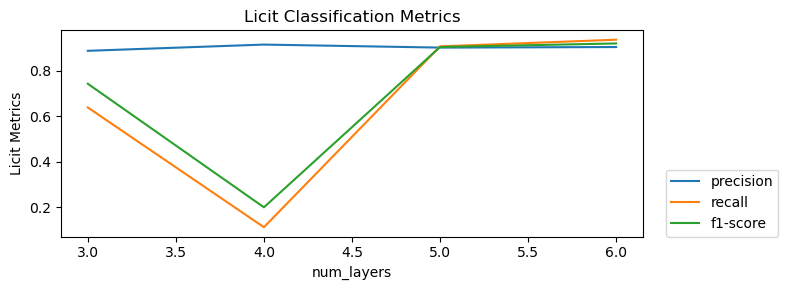

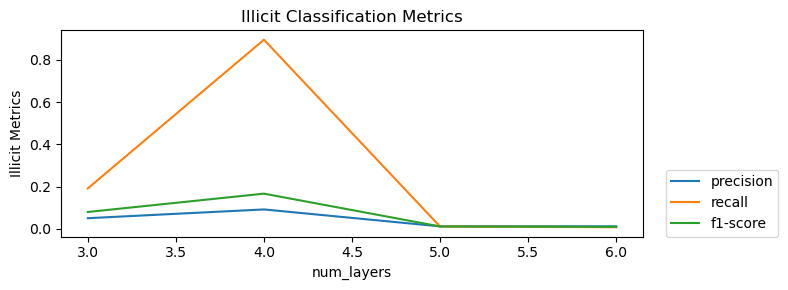

In [7]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Hidden Dimension

In [9]:
metrics = create_metrics()
para_change = "hid_dim"
para_list = [64, 128, 256, 512, 1024]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[20166, 93], edge_index=[2, 19946], y=[20166])
Using perturbation
creating model with {'hid_dim': 64, 'num_layers': 6, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'torch_geometric.nn.models.basic_gnn.GCN'>}
training model...
Epoch 0000: Loss 255.1987 | 
Epoch 0001: Loss 13.8927 | 
Epoch 0002: Loss 6.4511 | 
Epoch 0003: Loss 5.2651 | 
Epoch 0004: Loss 4.9614 | 
Epoch 0005: Loss 4.7904 | 
Epoch 0006: Loss 4.7476 | 
Epoch 0007: Loss 4.6492 | 
Epoch 0008: Loss 4.7339 | 
Epoch 0009: Loss 4.5957 | 
Epoch 0010: Loss 4.6009 | 
Epoch 0011: Loss 4.5847 | 
Epoch 0012: Loss 4.5477 | 
Epoch 0013: Loss 4.5433 | 
Epoch 0014: Loss 4.4872 | 
Epoch 0015: Loss 4.5102 | 
Epoch 0016: Loss 4.4541 | 
Epoch 0017: Loss 4.4444 | 
Epoch 0018: Loss 4.3841 | 
Epoch 0019: Loss 4.3770

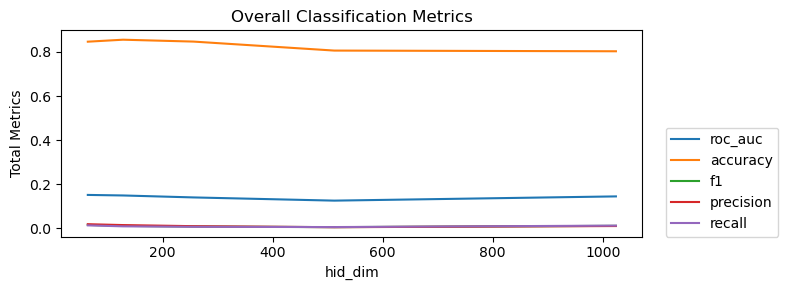

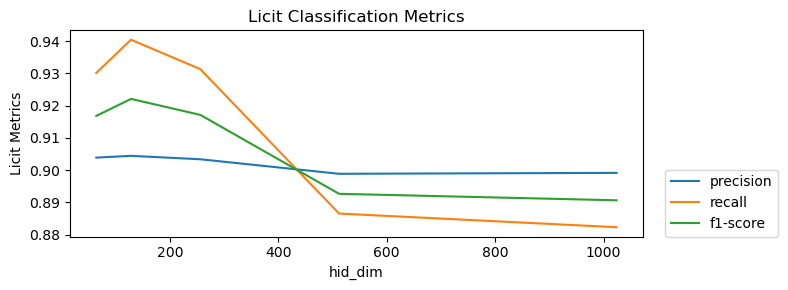

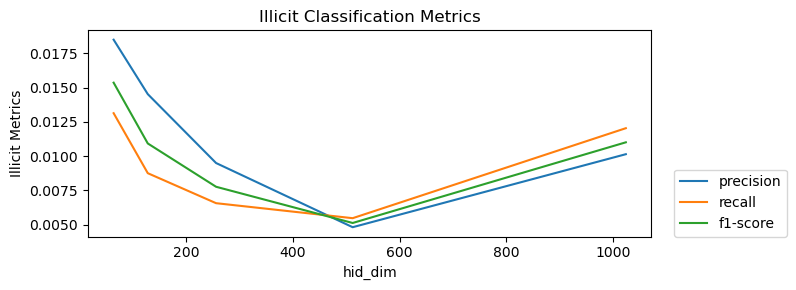

In [10]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Dropout

In [12]:
metrics = create_metrics()
para_change = "dropout"
para_list = [0.1, 0.15, 0.2]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[20166, 93], edge_index=[2, 19946], y=[20166])
Using perturbation
creating model with {'hid_dim': 1024, 'num_layers': 6, 'dropout': 0.1, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'torch_geometric.nn.models.basic_gnn.GCN'>}
training model...
Epoch 0000: Loss 232528.8896 | 
Epoch 0001: Loss 38.7125 | 
Epoch 0002: Loss 24.0549 | 
Epoch 0003: Loss 11.3978 | 
Epoch 0004: Loss 8.9315 | 
Epoch 0005: Loss 7.9435 | 
Epoch 0006: Loss 7.2319 | 
Epoch 0007: Loss 6.8995 | 
Epoch 0008: Loss 6.5737 | 
Epoch 0009: Loss 6.3033 | 
Epoch 0010: Loss 6.1914 | 
Epoch 0011: Loss 6.0851 | 
Epoch 0012: Loss 6.6730 | 
Epoch 0013: Loss 6.0675 | 
Epoch 0014: Loss 5.9800 | 
Epoch 0015: Loss 5.8512 | 
Epoch 0016: Loss 5.8110 | 
Epoch 0017: Loss 5.8213 | 
Epoch 0018: Loss 6.2740 | 
Epoch 0019: Loss

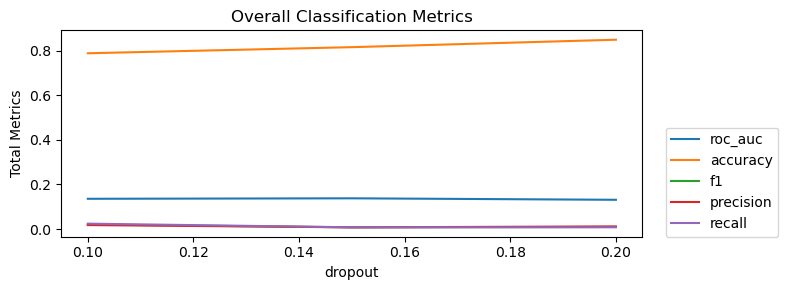

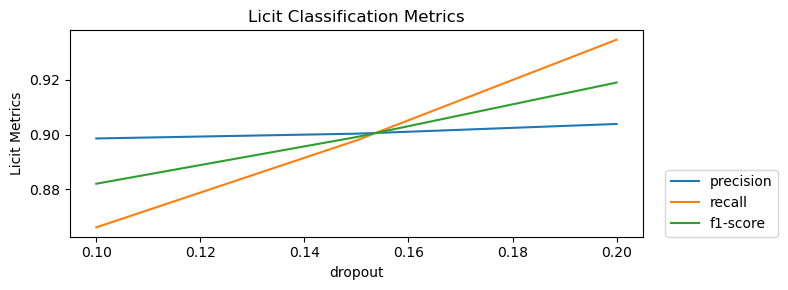

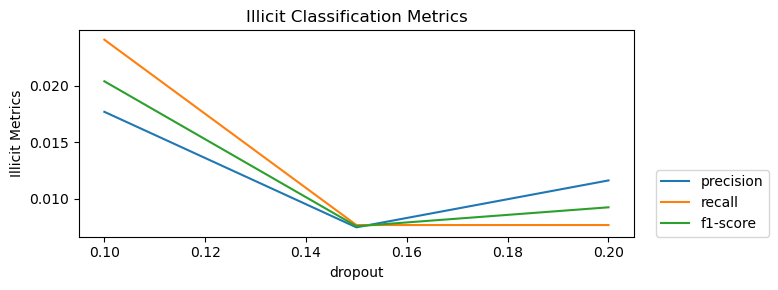

In [13]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Number of neighbors

In [15]:
metrics = create_metrics()
para_change = "num_neigh"
para_list = [10,15]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[20166, 93], edge_index=[2, 19946], y=[20166])
Using perturbation
creating model with {'hid_dim': 1024, 'num_layers': 6, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'torch_geometric.nn.models.basic_gnn.GCN'>}
training model...
Epoch 0000: Loss 230711.5011 | 
Epoch 0001: Loss 23.6769 | 
Epoch 0002: Loss 16.0510 | 
Epoch 0003: Loss 12.6521 | 
Epoch 0004: Loss 12.3883 | 
Epoch 0005: Loss 10.2599 | 
Epoch 0006: Loss 8.0507 | 
Epoch 0007: Loss 7.4120 | 
Epoch 0008: Loss 7.1184 | 
Epoch 0009: Loss 6.8642 | 
Epoch 0010: Loss 6.8555 | 
Epoch 0011: Loss 6.6763 | 
Epoch 0012: Loss 6.6467 | 
Epoch 0013: Loss 6.5642 | 
Epoch 0014: Loss 6.4534 | 
Epoch 0015: Loss 6.3915 | 
Epoch 0016: Loss 6.4274 | 
Epoch 0017: Loss 6.2994 | 
Epoch 0018: Loss 6.2238 | 
Epoch 0019: Lo

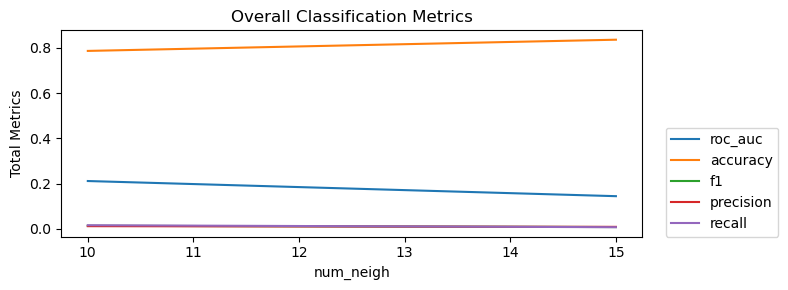

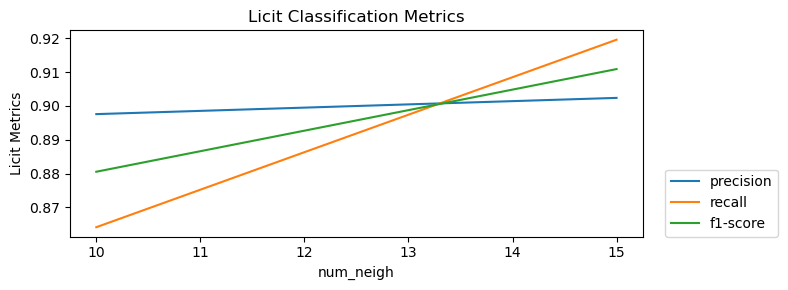

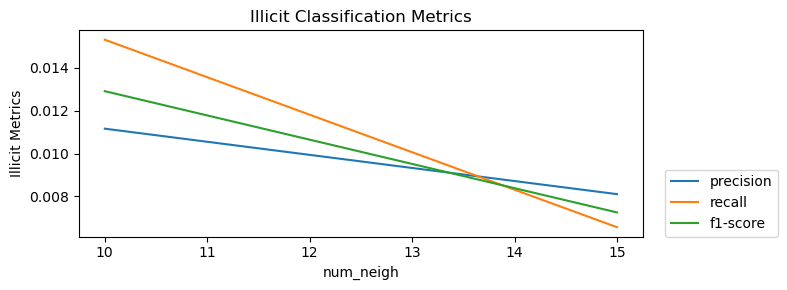

In [16]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Epochs

In [18]:
# metrics = create_metrics()
# para_change = "epoch"
# para_list = [50, 70]

# metrics = hyperparameter_loop("model", para_change, para_list, metrics)

In [19]:
# plot_metrics(metrics, para_list, para_change, x_log=False)

## DOMINANT using GAT backbone

In [21]:
config = {
        "model": {
            "hid_dim": 512,
            "num_layers": 6,
            "dropout": 0.2,
            "weight_decay": 0.0,
            "contamination": 0.1,
            "backbone": "gat",
            "lr": 0.005,
            "epoch": 30,
            "gpu":0.9,
            "batch_size": 2048,
            "num_neigh": 15,
            "weight": 0.5,
            "verbose": 1,
        },
        "data": {
            "use_aggregated": False,
            "use_temporal": False,
            "batch_size": 5000
        },
        "training": {
            "save_embeddings": False,
            "save_dir": "./saved_models",
        },
        "classifiers": ["rf", "mlp"],
        "transform":{
            "perturb":True,
            "interpolate":False,
        }
    }

#### Number of layers

In [23]:
metrics = create_metrics()
para_change = "num_layers"
para_list = [5,6,7]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[9996, 93], edge_index=[2, 10010], y=[9996])
Using perturbation
creating model with {'hid_dim': 512, 'num_layers': 5, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 15, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GATBackbone'>}
training model...
Epoch 0000: Loss 59728.8317 | 
Epoch 0001: Loss 18592.8592 | 
Epoch 0002: Loss 7198.2999 | 
Epoch 0003: Loss 2341.2212 | 
Epoch 0004: Loss 2233.5447 | 
Epoch 0005: Loss 1423.6867 | 
Epoch 0006: Loss 918.2167 | 
Epoch 0007: Loss 533.6989 | 
Epoch 0008: Loss 311.8042 | 
Epoch 0009: Loss 293.3830 | 
Epoch 0010: Loss 312.9631 | 
Epoch 0011: Loss 210.3634 | 
Epoch 0012: Loss 199.6303 | 
Epoch 0013: Loss 112.2272 | 
Epoch 0014: Loss 120.1161 | 
Epoch 0015: Loss 100.2866 | 
Epoch 0016: Loss 105.5603 | 
Epoch 0017: Loss 75.0469 | 
Epoch 0018: Loss 83.0086 |

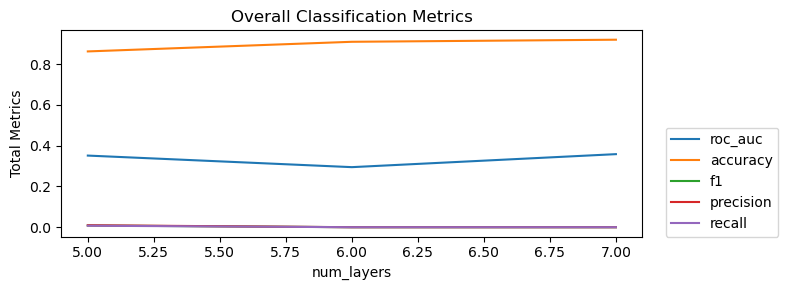

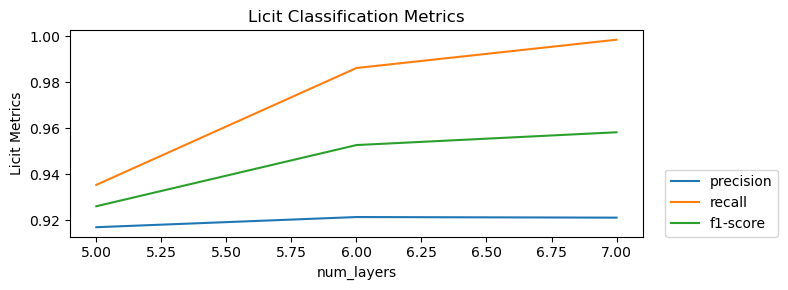

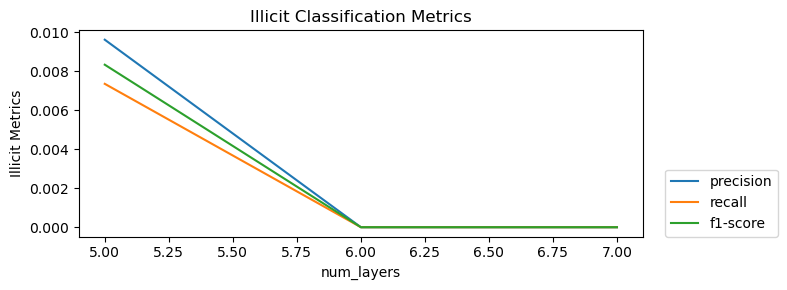

In [24]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Hidden Dimension

In [26]:
metrics = create_metrics()
para_change = "hid_dim"
para_list = [128, 256, 512]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using perturbation
creating model with {'hid_dim': 128, 'num_layers': 7, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 15, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GATBackbone'>}
training model...
Epoch 0000: Loss 2136.9657 | 
Epoch 0001: Loss 330.8841 | 
Epoch 0002: Loss 446.4810 | 
Epoch 0003: Loss 151.1634 | 
Epoch 0004: Loss 62.3868 | 
Epoch 0005: Loss 59.4321 | 
Epoch 0006: Loss 52.8697 | 
Epoch 0007: Loss 74.2561 | 
Epoch 0008: Loss 73.0512 | 
Epoch 0009: Loss 81.5947 | 
Epoch 0010: Loss 76.4186 | 
Epoch 0011: Loss 61.6821 | 
Epoch 0012: Loss 60.7480 | 
Epoch 0013: Loss 33.9969 | 
Epoch 0014: Loss 23.4735 | 
Epoch 0015: Loss 15.3373 | 
Epoch 0016: Loss 11.5118 | 
Epoch 0017: Loss 11.5648 | 
Epoch 0018: Loss 11.3295 | 
Epoch 0019: Loss

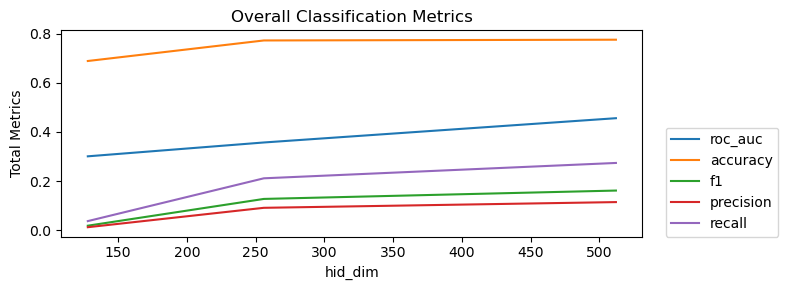

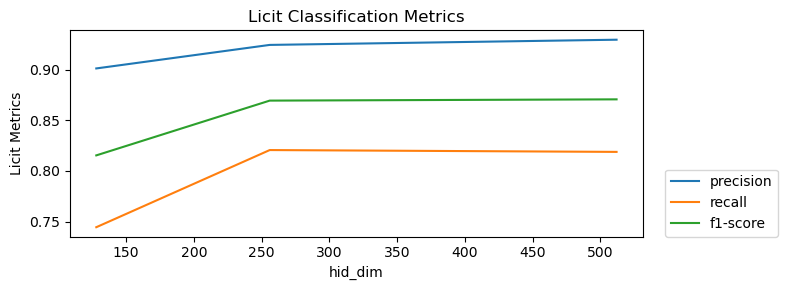

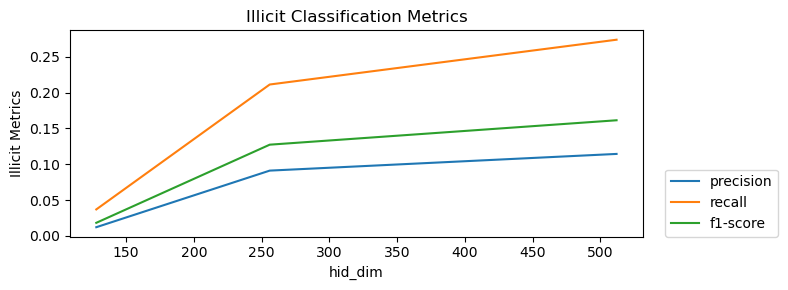

In [27]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Dropout

In [29]:
metrics = create_metrics()
para_change = "dropout"
para_list = [0.1, 0.15, 0.2]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using perturbation
creating model with {'hid_dim': 512, 'num_layers': 7, 'dropout': 0.1, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 15, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GATBackbone'>}
training model...
Epoch 0000: Loss 106758.4884 | 
Epoch 0001: Loss 12143.5192 | 
Epoch 0002: Loss 12558.9450 | 
Epoch 0003: Loss 5689.5323 | 
Epoch 0004: Loss 3737.6435 | 
Epoch 0005: Loss 2321.9086 | 
Epoch 0006: Loss 2242.4239 | 
Epoch 0007: Loss 1961.4461 | 
Epoch 0008: Loss 2069.8961 | 
Epoch 0009: Loss 2029.2343 | 
Epoch 0010: Loss 1982.4585 | 
Epoch 0011: Loss 2009.9595 | 
Epoch 0012: Loss 2869.6445 | 
Epoch 0013: Loss 3421.1713 | 
Epoch 0014: Loss 3932.8301 | 
Epoch 0015: Loss 4137.2647 | 
Epoch 0016: Loss 4910.4769 | 
Epoch 0017: Loss 5468.3007 | 
Epoch 001

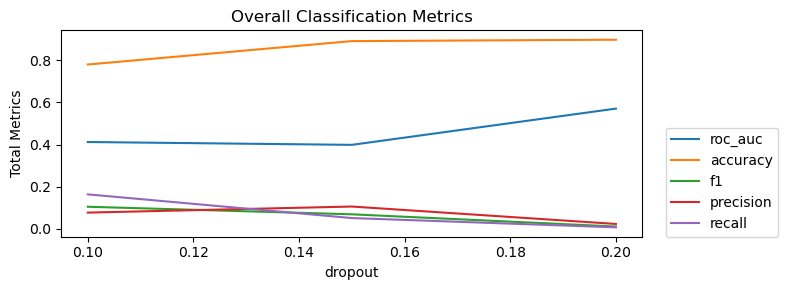

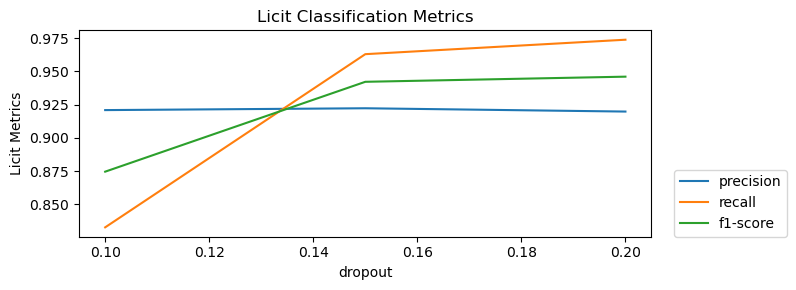

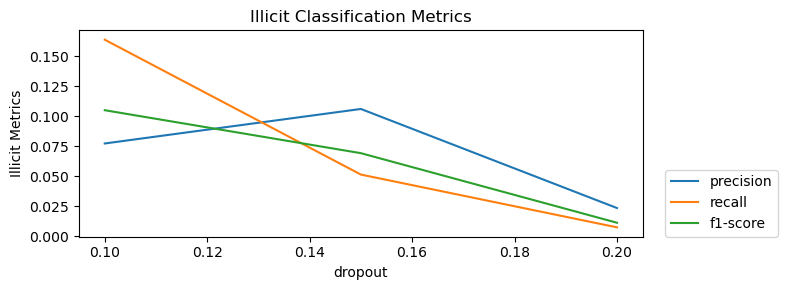

In [30]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Number of neighbors

In [32]:
metrics = create_metrics()
para_change = "num_neigh"
para_list = [10,15]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using perturbation
creating model with {'hid_dim': 512, 'num_layers': 7, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GATBackbone'>}
training model...
Epoch 0000: Loss 106651.8101 | 
Epoch 0001: Loss 15960.8836 | 
Epoch 0002: Loss 17940.3395 | 
Epoch 0003: Loss 12987.2170 | 
Epoch 0004: Loss 3478.2639 | 
Epoch 0005: Loss 5053.3504 | 
Epoch 0006: Loss 3954.4060 | 
Epoch 0007: Loss 1216.9243 | 
Epoch 0008: Loss 1331.1259 | 
Epoch 0009: Loss 975.8550 | 
Epoch 0010: Loss 290.1952 | 
Epoch 0011: Loss 278.0490 | 
Epoch 0012: Loss 230.2472 | 
Epoch 0013: Loss 177.9133 | 
Epoch 0014: Loss 122.8756 | 
Epoch 0015: Loss 117.8130 | 
Epoch 0016: Loss 104.6323 | 
Epoch 0017: Loss 90.5458 | 
Epoch 0018: Loss 7

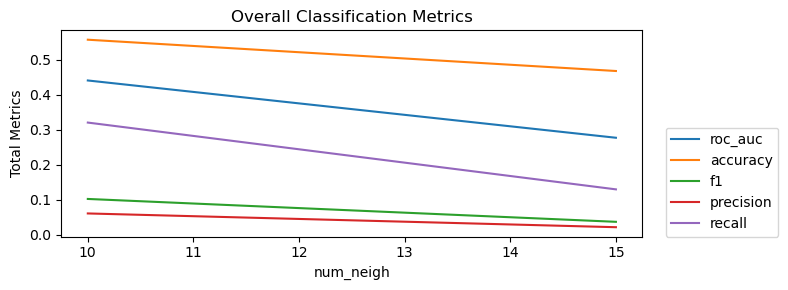

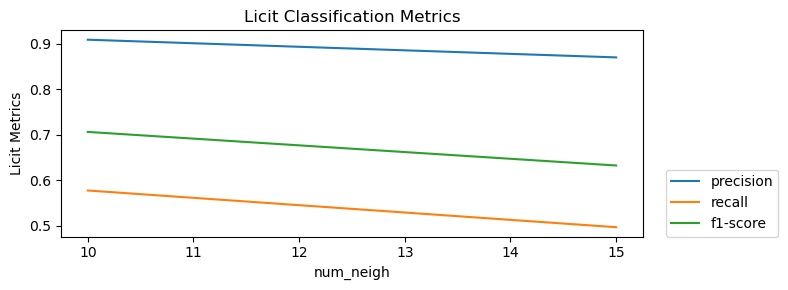

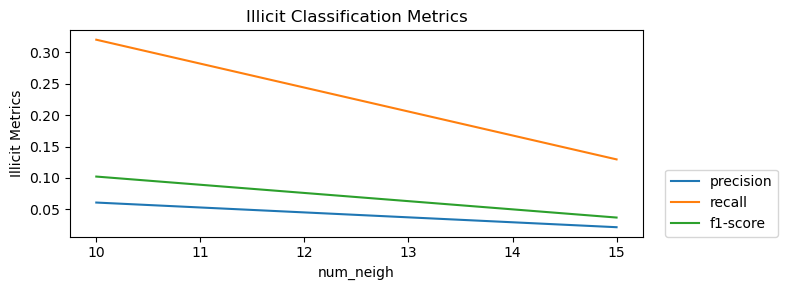

In [33]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Epochs

In [35]:
# metrics = create_metrics()
# para_change = "epoch"
# para_list = [10, 20 , 30 , 40, 50]

# metrics = hyperparameter_loop("model", para_change, para_list, metrics)

In [36]:
# plot_metrics(metrics, para_list, para_change, x_log=False)

## DOMINANT using hybrid GCN/GAT backbone

In [38]:
config = {
        "model": {
            "hid_dim": 512,
            "num_layers": 6,
            "dropout": 0.2,
            "weight_decay": 0.0,
            "contamination": 0.1,
            "backbone": "hybrid",
            "lr": 0.005,
            "epoch": 30,
            "gpu":0.9,
            "batch_size": 2048,
            "num_neigh": 10,
            "weight": 0.5,
            "verbose": 1,
        },
        "data": {
            "use_aggregated": False,
            "use_temporal": False,
            "batch_size": 5000
        },
        "training": {
            "save_embeddings": False,
            "save_dir": "./saved_models",
        },
        "classifiers": ["rf", "mlp"],
        "transform":{
            "perturb":True,
            "interpolate":False,
        }
    }

#### Number of layers

In [40]:
metrics = create_metrics()
para_change = "num_layers"
para_list = [4, 5, 6, 7]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using perturbation
creating model with {'hid_dim': 512, 'num_layers': 4, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.HybridGCNGATBackbone'>}
training model...
Epoch 0000: Loss 5960.5094 | 
Epoch 0001: Loss 3601.0780 | 
Epoch 0002: Loss 2796.9383 | 
Epoch 0003: Loss 2518.2824 | 
Epoch 0004: Loss 2319.3193 | 
Epoch 0005: Loss 2104.9155 | 
Epoch 0006: Loss 1903.5881 | 
Epoch 0007: Loss 1736.1101 | 
Epoch 0008: Loss 1602.8241 | 
Epoch 0009: Loss 1483.9829 | 
Epoch 0010: Loss 1397.2438 | 
Epoch 0011: Loss 1290.1355 | 
Epoch 0012: Loss 1190.8581 | 
Epoch 0013: Loss 1073.4784 | 
Epoch 0014: Loss 991.8665 | 
Epoch 0015: Loss 870.0231 | 
Epoch 0016: Loss 762.9916 | 
Epoch 0017: Loss 621.0679 | 
Epoch 00

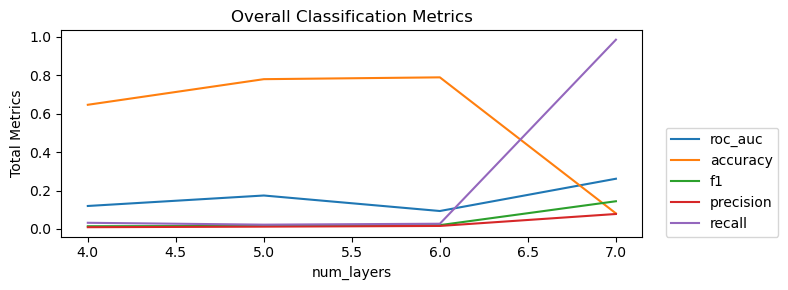

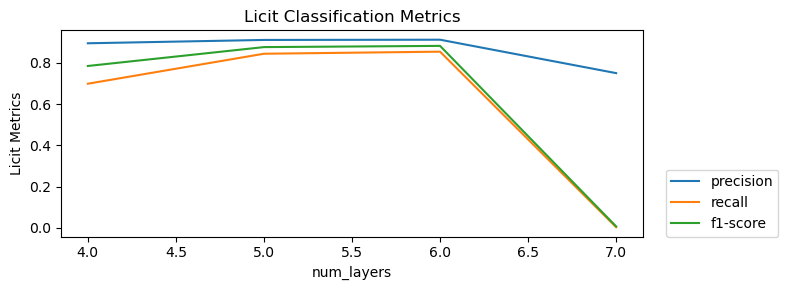

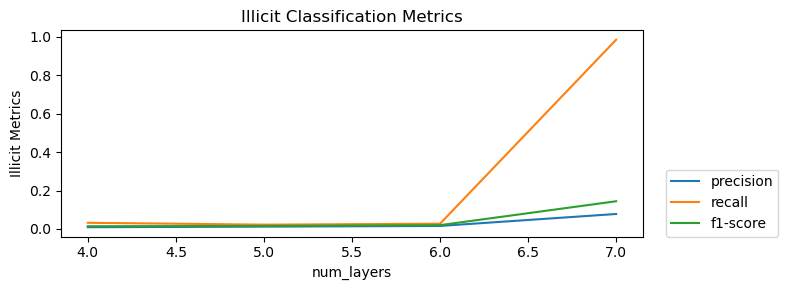

In [41]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Hidden Dimension

In [43]:
metrics = create_metrics()
para_change = "hid_dim"
para_list = [128, 256, 512, 1024]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using perturbation
creating model with {'hid_dim': 128, 'num_layers': 7, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.HybridGCNGATBackbone'>}
training model...
Epoch 0000: Loss 928.8034 | 
Epoch 0001: Loss 533.3631 | 
Epoch 0002: Loss 338.6334 | 
Epoch 0003: Loss 266.6533 | 
Epoch 0004: Loss 220.2385 | 
Epoch 0005: Loss 181.5805 | 
Epoch 0006: Loss 162.6394 | 
Epoch 0007: Loss 157.2061 | 
Epoch 0008: Loss 148.5500 | 
Epoch 0009: Loss 135.3222 | 
Epoch 0010: Loss 130.8281 | 
Epoch 0011: Loss 133.9529 | 
Epoch 0012: Loss 121.0582 | 
Epoch 0013: Loss 123.4602 | 
Epoch 0014: Loss 112.2027 | 
Epoch 0015: Loss 114.6751 | 
Epoch 0016: Loss 113.6390 | 
Epoch 0017: Loss 110.2829 | 
Epoch 0018: Loss 112.1

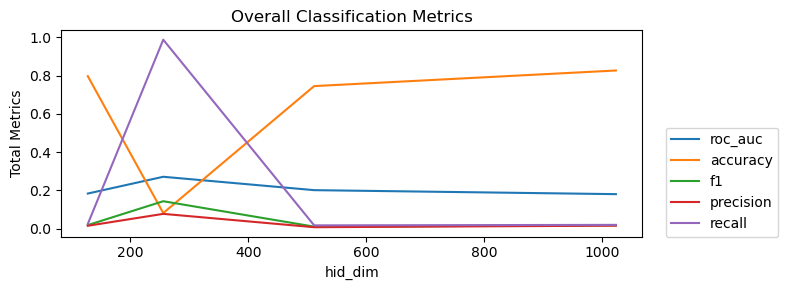

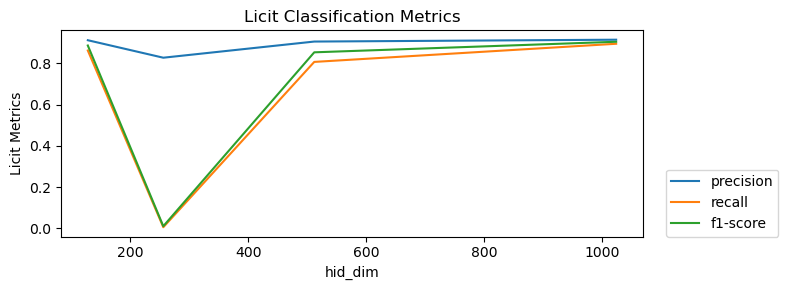

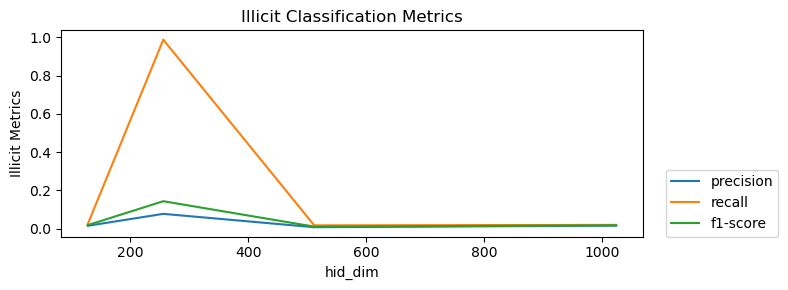

In [44]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Dropout

In [46]:
metrics = create_metrics()
para_change = "dropout"
para_list = [0.1, 0.15, 0.2]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using perturbation
creating model with {'hid_dim': 1024, 'num_layers': 7, 'dropout': 0.1, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.HybridGCNGATBackbone'>}
training model...
Epoch 0000: Loss 10610.5223 | 
Epoch 0001: Loss 5706.4502 | 
Epoch 0002: Loss 4865.5796 | 
Epoch 0003: Loss 4114.3255 | 
Epoch 0004: Loss 3198.4802 | 
Epoch 0005: Loss 3431.6451 | 
Epoch 0006: Loss 3303.8422 | 
Epoch 0007: Loss 2738.4759 | 
Epoch 0008: Loss 2392.1633 | 
Epoch 0009: Loss 1963.6919 | 
Epoch 0010: Loss 1742.5419 | 
Epoch 0011: Loss 1458.6659 | 
Epoch 0012: Loss 1280.7177 | 
Epoch 0013: Loss 1129.5449 | 
Epoch 0014: Loss 997.1533 | 
Epoch 0015: Loss 888.9362 | 
Epoch 0016: Loss 829.0021 | 
Epoch 0017: Loss 768.6969 | 
Epoch 

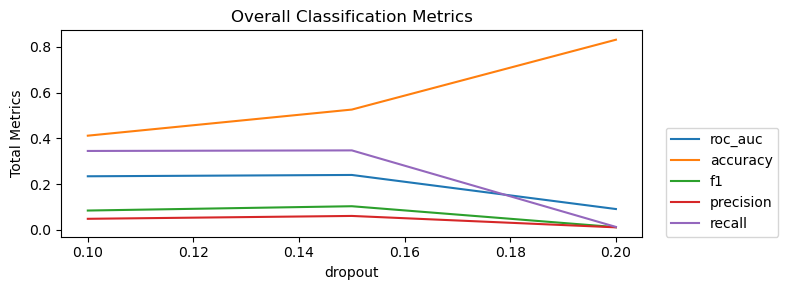

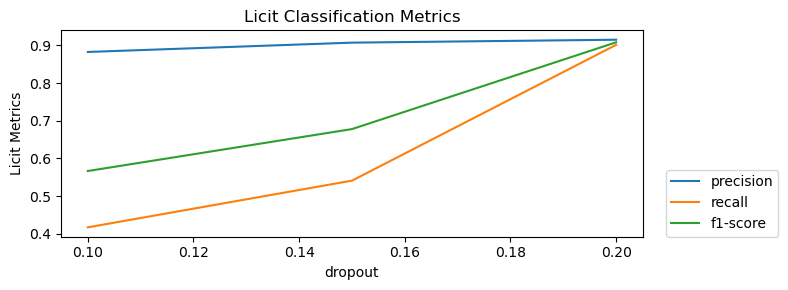

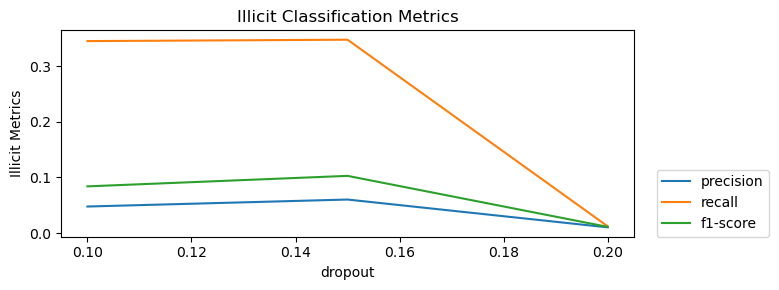

In [47]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Number of neighbors

In [49]:
metrics = create_metrics()
para_change = "num_neigh"
para_list = [10,15]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using perturbation
creating model with {'hid_dim': 1024, 'num_layers': 7, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.HybridGCNGATBackbone'>}
training model...
Epoch 0000: Loss 9958.6485 | 
Epoch 0001: Loss 5076.0558 | 
Epoch 0002: Loss 3834.5685 | 
Epoch 0003: Loss 3171.4827 | 
Epoch 0004: Loss 3055.6245 | 
Epoch 0005: Loss 2721.8607 | 
Epoch 0006: Loss 2601.5579 | 
Epoch 0007: Loss 2368.1752 | 
Epoch 0008: Loss 2137.6643 | 
Epoch 0009: Loss 1928.4808 | 
Epoch 0010: Loss 1722.1875 | 
Epoch 0011: Loss 1626.1981 | 
Epoch 0012: Loss 1503.4478 | 
Epoch 0013: Loss 1395.0034 | 
Epoch 0014: Loss 1272.0004 | 
Epoch 0015: Loss 1144.5022 | 
Epoch 0016: Loss 1003.1202 | 
Epoch 0017: Loss 878.6645 | 
Epoc

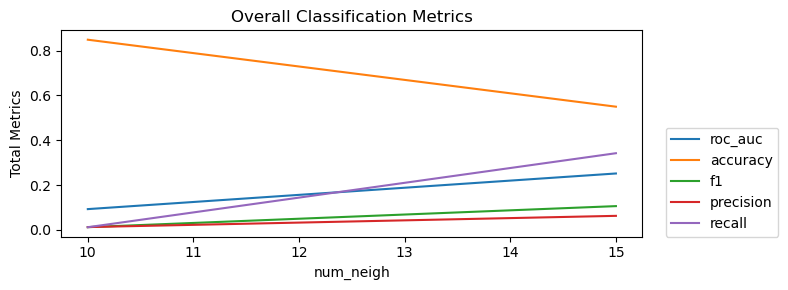

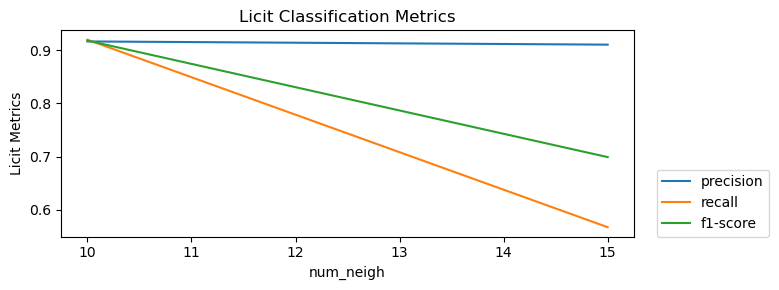

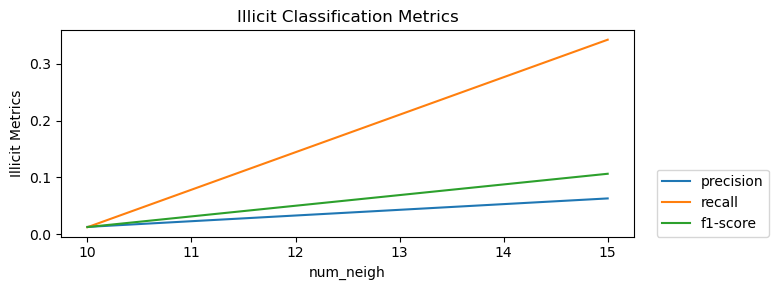

In [50]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Epochs

In [52]:
# metrics = create_metrics()
# para_change = "epoch"
# para_list = [40, 50]

# metrics = hyperparameter_loop("model", para_change, para_list, metrics)

In [53]:
# plot_metrics(metrics, para_list, para_change, x_log=False)

## DOMINANT using Skip-GCN Backbone

In [55]:
config = {
        "model": {
            "hid_dim": 512,
            "num_layers": 6,
            "dropout": 0.2,
            "weight_decay": 0.0,
            "contamination": 0.1,
            "backbone": "gcn_skip",
            "lr": 0.005,
            "epoch": 30,
            "gpu":0.9,
            "batch_size": 2048,
            "num_neigh": 10,
            "weight": 0.5,
            "verbose": 1,
        },
        "data": {
            "use_aggregated": False,
            "use_temporal": False,
            "batch_size": 5000
        },
        "training": {
            "save_embeddings": False,
            "save_dir": "./saved_models",
        },
        "classifiers": ["rf", "mlp"],
        "transform":{
            "perturb":True,
            "interpolate":False,
        }
    }

#### Number of Layers

In [57]:
metrics = create_metrics()
para_change = "num_layers"
para_list = [4, 5, 6, 7]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using perturbation
creating model with {'hid_dim': 512, 'num_layers': 4, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GCNSkipBackbone'>}
training model...
Epoch 0000: Loss 8435.9332 | 
Epoch 0001: Loss 2716.0667 | 
Epoch 0002: Loss 1449.7423 | 
Epoch 0003: Loss 920.6913 | 
Epoch 0004: Loss 657.6400 | 
Epoch 0005: Loss 501.4890 | 
Epoch 0006: Loss 414.2974 | 
Epoch 0007: Loss 349.9869 | 
Epoch 0008: Loss 311.8313 | 
Epoch 0009: Loss 279.1802 | 
Epoch 0010: Loss 244.4894 | 
Epoch 0011: Loss 237.7293 | 
Epoch 0012: Loss 217.6708 | 
Epoch 0013: Loss 215.2504 | 
Epoch 0014: Loss 198.5444 | 
Epoch 0015: Loss 190.0347 | 
Epoch 0016: Loss 191.4455 | 
Epoch 0017: Loss 181.0414 | 
Epoch 0018: Loss 183.648

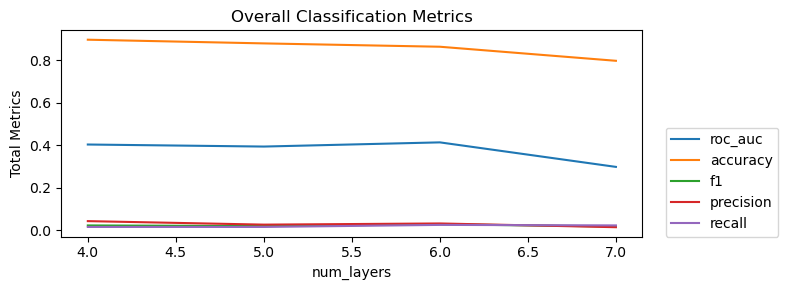

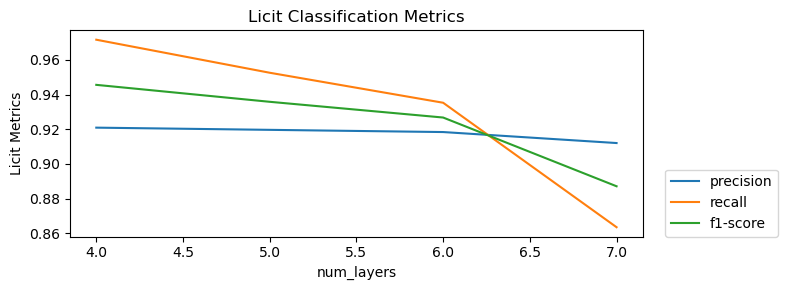

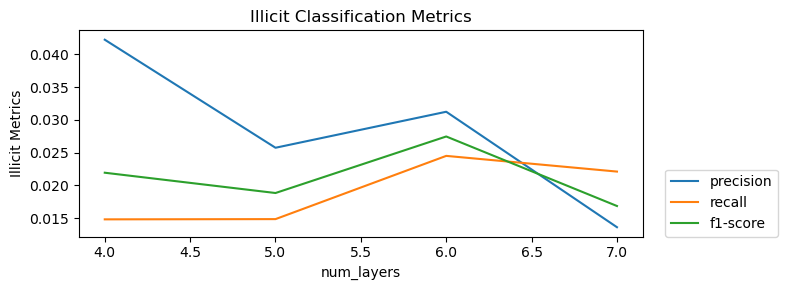

In [58]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Hidden Dimension

In [60]:
metrics = create_metrics()
para_change = "hid_dim"
para_list = [128, 256, 512, 1024]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using perturbation
creating model with {'hid_dim': 128, 'num_layers': 7, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GCNSkipBackbone'>}
training model...
Epoch 0000: Loss 2571.5950 | 
Epoch 0001: Loss 379.8401 | 
Epoch 0002: Loss 219.0042 | 
Epoch 0003: Loss 175.5592 | 
Epoch 0004: Loss 148.7881 | 
Epoch 0005: Loss 131.0572 | 
Epoch 0006: Loss 112.4254 | 
Epoch 0007: Loss 103.7104 | 
Epoch 0008: Loss 94.9105 | 
Epoch 0009: Loss 83.4797 | 
Epoch 0010: Loss 84.6313 | 
Epoch 0011: Loss 77.9152 | 
Epoch 0012: Loss 74.5468 | 
Epoch 0013: Loss 68.6488 | 
Epoch 0014: Loss 65.3818 | 
Epoch 0015: Loss 65.4480 | 
Epoch 0016: Loss 64.9915 | 
Epoch 0017: Loss 60.7697 | 
Epoch 0018: Loss 56.1252 | 
Epoch 00

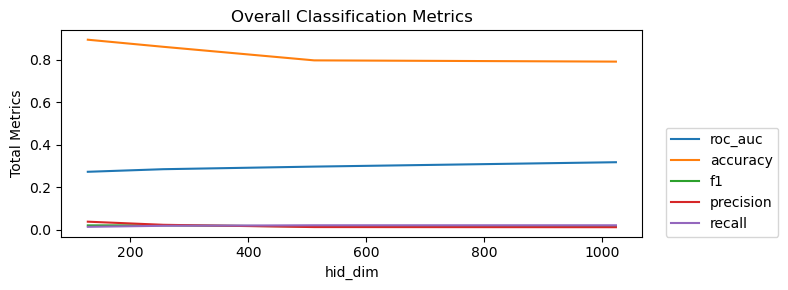

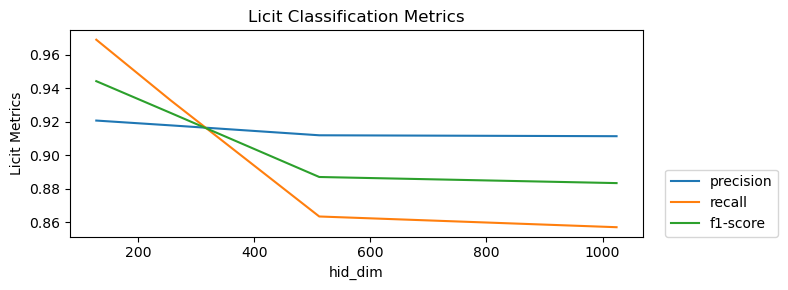

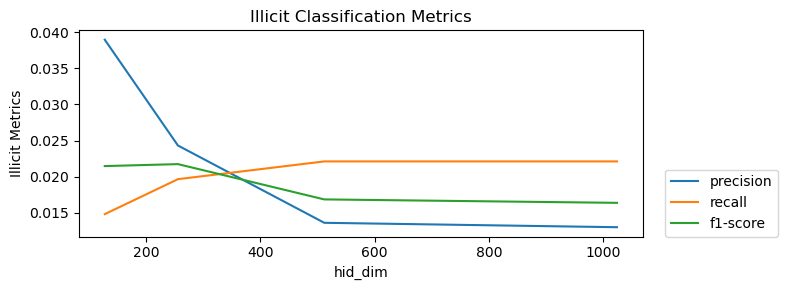

In [61]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Dropout

In [63]:
metrics = create_metrics()
para_change = "dropout"
para_list = [0.1, 0.15, 0.2]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using perturbation
creating model with {'hid_dim': 1024, 'num_layers': 7, 'dropout': 0.1, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GCNSkipBackbone'>}
training model...
Epoch 0000: Loss 27761.0136 | 
Epoch 0001: Loss 8337.2976 | 
Epoch 0002: Loss 5018.0386 | 
Epoch 0003: Loss 3517.6734 | 
Epoch 0004: Loss 2736.9284 | 
Epoch 0005: Loss 2250.4047 | 
Epoch 0006: Loss 1906.6119 | 
Epoch 0007: Loss 1616.4249 | 
Epoch 0008: Loss 1373.6783 | 
Epoch 0009: Loss 1176.5872 | 
Epoch 0010: Loss 1027.0913 | 
Epoch 0011: Loss 895.0088 | 
Epoch 0012: Loss 784.5947 | 
Epoch 0013: Loss 693.9790 | 
Epoch 0014: Loss 627.0506 | 
Epoch 0015: Loss 574.5329 | 
Epoch 0016: Loss 525.6811 | 
Epoch 0017: Loss 484.7983 | 
Epoch 0018: Lo

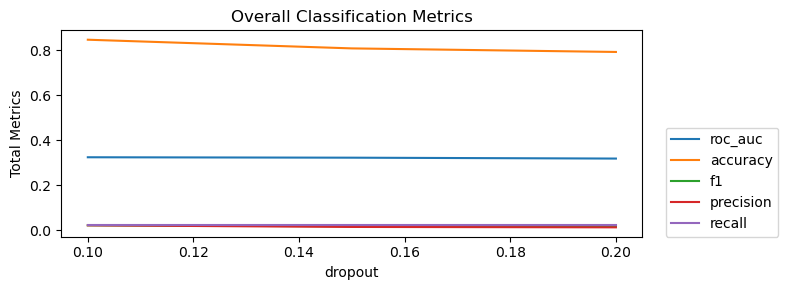

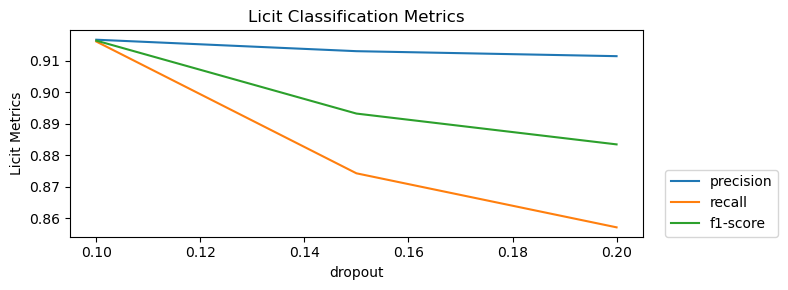

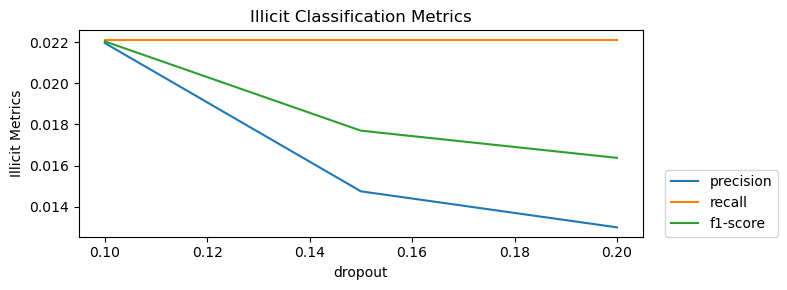

In [64]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Number of neighbors

In [66]:
metrics = create_metrics()
para_change = "num_neigh"
para_list = [10,15]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using perturbation
creating model with {'hid_dim': 1024, 'num_layers': 7, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001FD8706DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GCNSkipBackbone'>}
training model...
Epoch 0000: Loss 27631.4476 | 
Epoch 0001: Loss 8272.6821 | 
Epoch 0002: Loss 4547.4423 | 
Epoch 0003: Loss 3022.3728 | 
Epoch 0004: Loss 2315.7289 | 
Epoch 0005: Loss 1848.5461 | 
Epoch 0006: Loss 1562.5141 | 
Epoch 0007: Loss 1317.4179 | 
Epoch 0008: Loss 1088.9691 | 
Epoch 0009: Loss 976.2370 | 
Epoch 0010: Loss 871.3963 | 
Epoch 0011: Loss 764.9617 | 
Epoch 0012: Loss 696.9248 | 
Epoch 0013: Loss 662.3581 | 
Epoch 0014: Loss 603.6999 | 
Epoch 0015: Loss 580.4889 | 
Epoch 0016: Loss 569.7929 | 
Epoch 0017: Loss 532.7255 | 
Epoch 0018: Loss

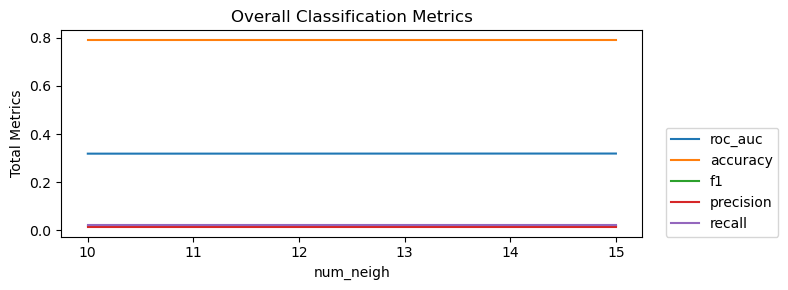

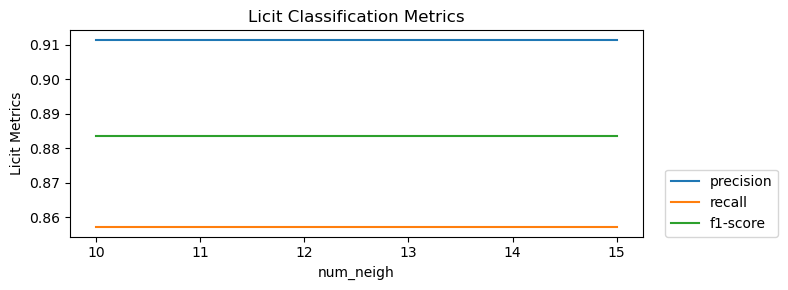

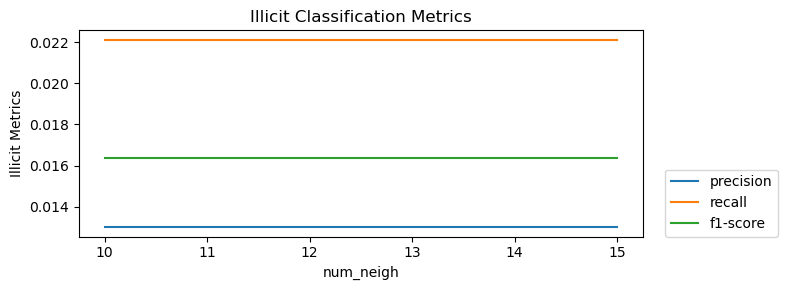

In [67]:
plot_metrics(metrics, para_list, para_change, x_log=False)